In [1]:
import numpy as np
import pandas as pd

# Read Data

In [471]:
df = pd.read_csv("full_data.csv")
df

,Unnamed: 0,grants,size,packages,alters,commands,commits,time,md
0,0,14,6039,87,2,955,23,44.344,0
1,1,11,5811,87,2,902,17,8.766,0
2,2,11,193,0,0,43,2,1.982,0
3,3,0,36,0,0,9,0,0.488,0
4,4,0,23,0,0,0,0,0.419,0
...,...,...,...,...,...,...,...,...,...
2056,207,1,33,2,1,8,1,0.43,1
2057,208,2,34,3,5,5,0,0.858,1
2058,209,2,42,5,3,9,0,0.993,1
2059,210,1,34,4,3,6,0,1.235,1


In [477]:
df.dropna(inplace=True)

In [483]:
df[df["time"] == 'O/S Message: No such file or directory']

,Unnamed: 0,grants,size,packages,alters,commands,commits,time,md
855,855,0,1,0,0,0,0,O/S Message: No such file or directory,0


In [484]:
df.drop(855, inplace=True)

In [494]:
df.to_csv("full_data.csv")

In [485]:
dfr = df[df['md'] == 0]

In [486]:
inputs = df.drop(["time", "Unnamed: 0"], axis=1)
target = df.time

## Split train-test dataset

In [487]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.3,random_state=42)

## Try base line for regression

In [488]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


def get_model_metrics(actual, predicted):
    print("RMSE: %0.2f" % (mean_squared_error(actual, predicted)))
    print("r2_score:  %0.2f" % r2_score(actual, predicted))


In [489]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
pred_train = linear_reg.predict(X_train)
pred_test = linear_reg.predict(X_test)
print("Train:")
get_model_metrics(y_train, pred_train)
print("Test:")
get_model_metrics(y_test, pred_test)

Train:
RMSE: 3441.64
r2_score:  0.53
Test:
RMSE: 16763.64
r2_score:  -1.52


In [490]:
from matplotlib import pyplot as plt


ref = np.linspace(min(y_train),max(y_train))
fig = plt.figure(figsize=(10,8))
plt.scatter(y_train,pred_train)
plt.plot(ref,ref,'k--')
plt.axis('square')
plt.xlabel('y real'),plt.ylabel('y predict')
plt.title('Linear regression TRAIN (original), RMSE=%0.4f, R^2=%0.4f'%(mean_squared_error(y_train,pred_train ),r2_score(y_train,pred_train)))
plt.grid()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U5'), dtype('float64')) -> None

In [491]:
ref = np.linspace(min(y_test),max(y_test))
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,pred_test)
plt.plot(ref,ref,'k--')
plt.axis('square')
plt.xlabel('y real'),plt.ylabel('y predict')
plt.title('Linear regression TEST (original), RMSE=%0.4f, R^2=%0.4f'%(mean_squared_error(y_test,pred_test ),r2_score(y_test,pred_test)))
plt.grid()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U5'), dtype('float64')) -> None

## Data preprocessing

array([[<Axes: title={'center': 'grants'}>,
        <Axes: title={'center': 'size'}>,
        <Axes: title={'center': 'packages'}>],
       [<Axes: title={'center': 'alters'}>,
        <Axes: title={'center': 'commands'}>,
        <Axes: title={'center': 'commits'}>],
       [<Axes: title={'center': 'md'}>, <Axes: >, <Axes: >]], dtype=object)

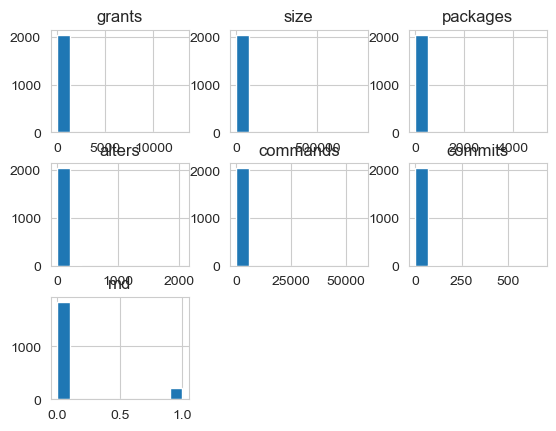

In [492]:
inputs.hist()

There is an important problem with the scale of the data. There are certain outliers that differs by a lot in the scale causing potential issues. 

In [83]:
inputs.describe()

,grants,size,packages,alters,commands,commits,md
count,192.000000,192.00000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,264.078125,14679.09375,112.859375,54.104167,1400.260417,19.494792,0.145833
std,1213.269232,76532.27445,548.452173,231.863111,5302.177375,74.861338,0.353862
min,0.000000,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,496.50000,0.000000,0.000000,85.250000,0.000000,0.000000
50%,26.000000,1969.50000,6.000000,2.000000,354.000000,0.000000,0.000000
75%,110.500000,5100.25000,34.250000,15.750000,769.500000,6.000000,0.000000
max,12985.000000,772433.00000,5120.000000,2054.000000,57015.000000,674.000000,1.000000


skewness is completely thrown off: 

In [84]:
inputs.skew()

grants      8.831094
size        9.083202
packages    8.247610
alters      7.375338
commands    8.356815
commits     7.348811
md          2.022794
dtype: float64

Let's try to mitigate the skewness using a power transformation (except md which is a binary variable). The goal itself of doing the power transformation is to reduce the scale, rather than mitigate the skewness.

If we try doing scaling (z), then it seems like it gets into numerical issues:

In [106]:
from sklearn import preprocessing
trans_inputs= pd.DataFrame(preprocessing.scale(inputs.drop("md", axis=1)))
trans_inputs.columns = inputs.columns[:6]

In [107]:
trans_inputs.describe()

,grants,size,packages,alters,commands,commits
count,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02,1.920000e+02
mean,-1.850372e-17,2.775558e-17,-9.251859e-18,-3.700743e-17,-2.775558e-17,-2.775558e-17
std,1.002614e+00,1.002614e+00,1.002614e+00,1.002614e+00,1.002614e+00,1.002614e+00
min,-2.182273e-01,-1.922386e-01,-2.063160e-01,-2.339554e-01,-2.647820e-01,-2.610928e-01
25%,-2.182273e-01,-1.857997e-01,-2.063160e-01,-2.339554e-01,-2.486617e-01,-2.610928e-01
50%,-1.967416e-01,-1.665026e-01,-1.953475e-01,-2.253070e-01,-1.978424e-01,-2.610928e-01
75%,-1.269130e-01,-1.254881e-01,-1.437042e-01,-1.658498e-01,-1.192735e-01,-1.807351e-01
max,1.051224e+01,9.926988e+00,9.153453e+00,8.647880e+00,1.051646e+01,8.765758e+00


Let's better try with a power transformation

In [116]:
trans_inputs = pd.DataFrame(inputs.drop("md", axis=1) ** (1/4))
trans_inputs.columns = inputs.columns[:6]

In [117]:
trans_inputs.describe()

,grants,size,packages,alters,commands,commits
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,2.147896,7.129233,1.634072,1.288009,4.401794,0.911024
std,1.981392,4.060268,1.577741,1.372615,2.216620,1.143015
min,0.000000,1.495349,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.720344,0.000000,0.000000,3.038534,0.000000
50%,2.257788,6.661671,1.565085,1.189207,4.337496,0.000000
75%,3.242187,8.450251,2.419127,1.990934,5.266790,1.565085
max,10.674818,29.645939,8.458970,6.732093,15.452448,5.095244


In [118]:
trans_inputs.skew()

grants      0.959892
size        2.160348
packages    1.240987
alters      1.204564
commands    1.471747
commits     1.122297
dtype: float64

array([[<Axes: title={'center': 'grants'}>,
        <Axes: title={'center': 'size'}>],
       [<Axes: title={'center': 'packages'}>,
        <Axes: title={'center': 'alters'}>],
       [<Axes: title={'center': 'commands'}>,
        <Axes: title={'center': 'commits'}>]], dtype=object)

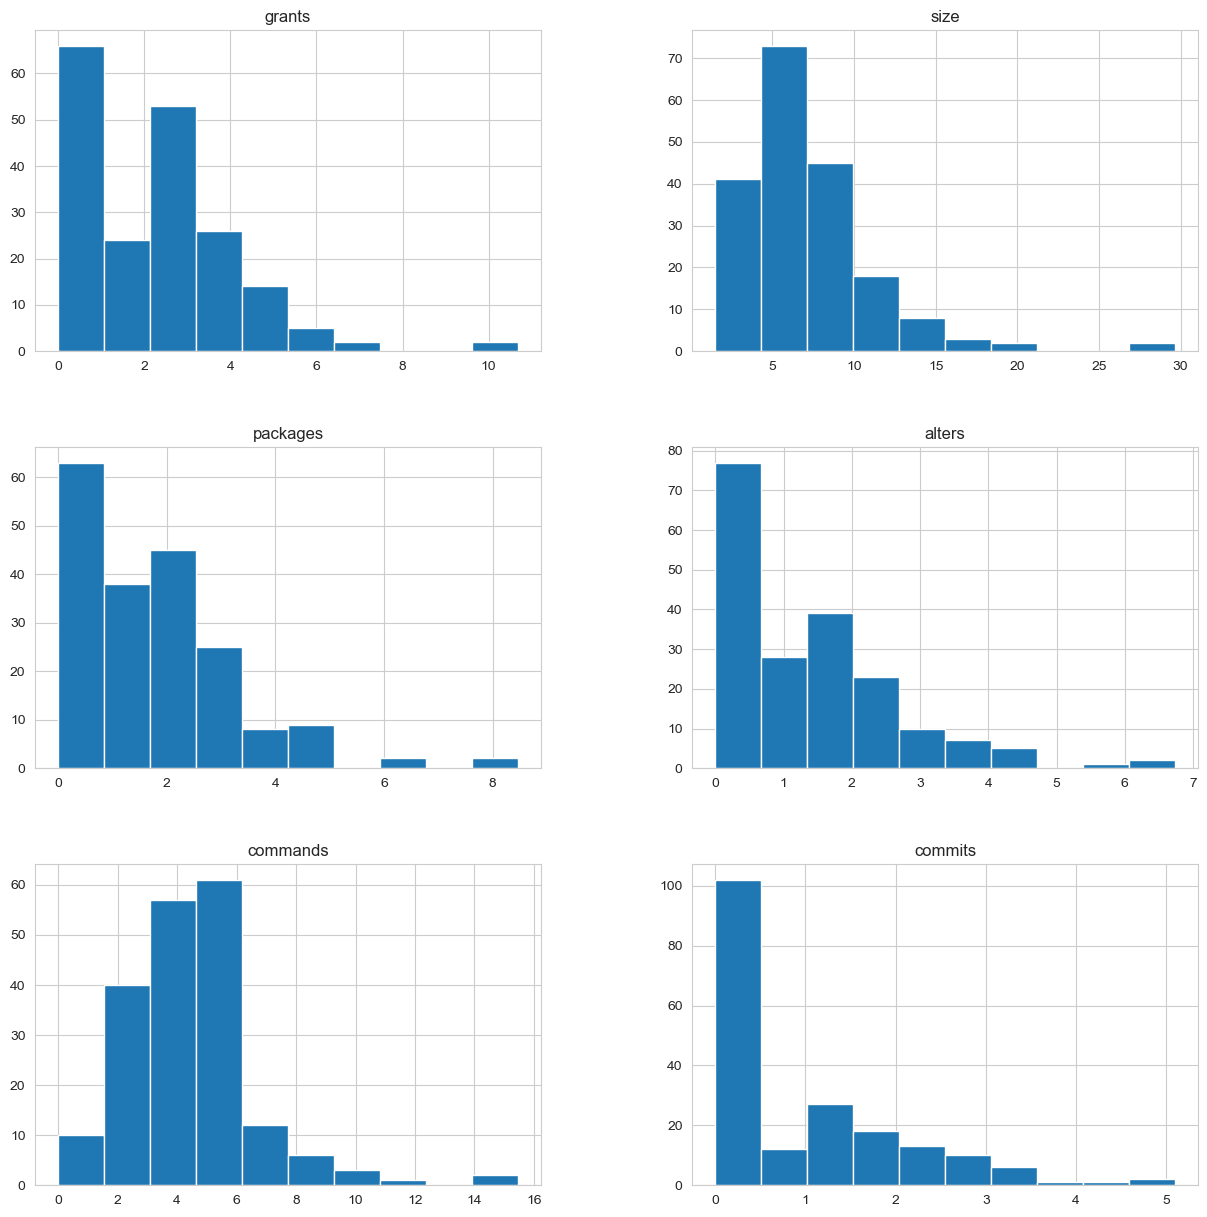

In [119]:
trans_inputs.hist(figsize=(15,15))

A transformation of power to the (1/4) works well for most variables, only size seems to require a more aggresive transformation, so we are doing it with 1/6. 

In [128]:
trans_inputs["size"] = inputs["size"] ** (1/6)

In [129]:
trans_inputs["size"].skew()

1.2165336258519859

array([[<Axes: title={'center': 'grants'}>,
        <Axes: title={'center': 'size'}>],
       [<Axes: title={'center': 'packages'}>,
        <Axes: title={'center': 'alters'}>],
       [<Axes: title={'center': 'commands'}>,
        <Axes: title={'center': 'commits'}>]], dtype=object)

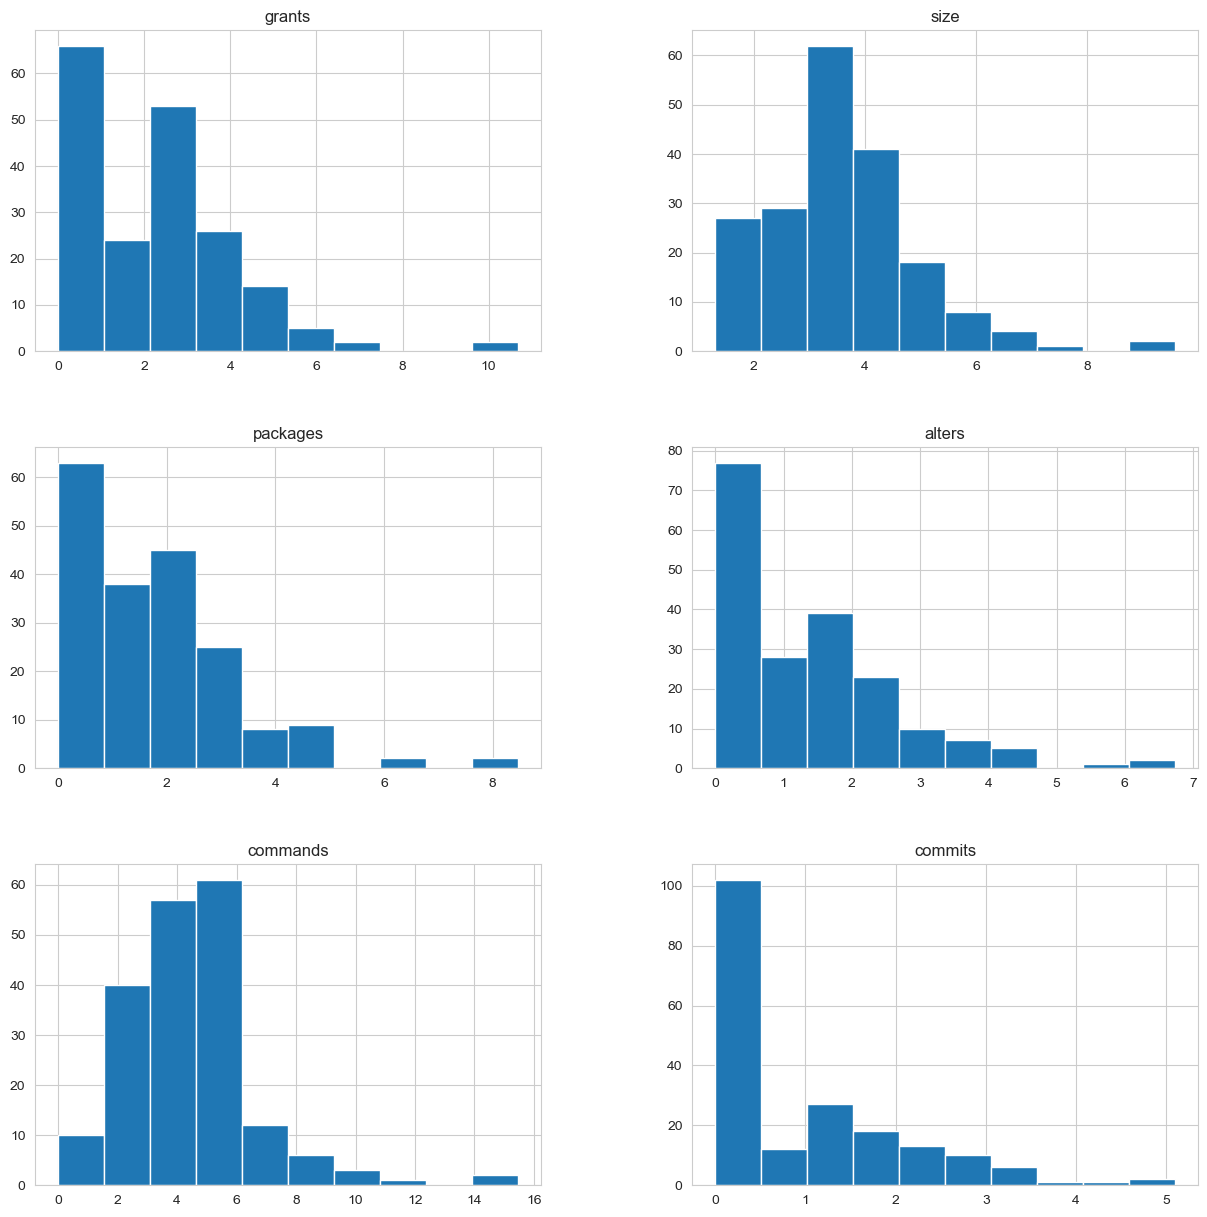

In [130]:
trans_inputs.hist(figsize=(15,15))

In [131]:
trans_inputs.skew()

grants      0.959892
size        1.216534
packages    1.240987
alters      1.204564
commands    1.471747
commits     1.122297
dtype: float64

For now these transformations should be enough to proceed.

In [147]:
from sklearn import preprocessing
trans_inputs= pd.DataFrame(preprocessing.scale(inputs.drop("md", axis=1)))
trans_inputs.columns = inputs.columns[:6]
trans_inputs["md"] = inputs["md"]

## Resample train-test from transformed data

In [292]:
dfr = df[df['md'] == 0]
inputs = dfr.drop(["time", "Unnamed: 0"], axis=1)
target = dfr.time


In [291]:
trans_inputs = pd.DataFrame(inputs.drop("md", axis=1) ** (1/4))
trans_inputs.columns = inputs.columns[:6]

In [293]:
from sklearn import preprocessing
trans_inputs= pd.DataFrame(preprocessing.scale(inputs.drop("md", axis=1)))
trans_inputs.columns = inputs.columns[:6]

In [305]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(trans_inputs, target, test_size=0.3,random_state=42)

X_train, X_, y_train, Y_ = train_test_split(trans_inputs, target, test_size=0.3, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, Y_, test_size=0.5, random_state=42)

### Base Linear model with transformed data

In [258]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
pred_train = linear_reg.predict(X_train)
pred_test = linear_reg.predict(X_test)
print("Train:")
get_model_metrics(y_train, pred_train)
print("Test:")
get_model_metrics(y_test, pred_test)

Train:
RMSE: 2461.05
r2_score:  0.91
Test:
RMSE: 1516.31
r2_score:  -7.76


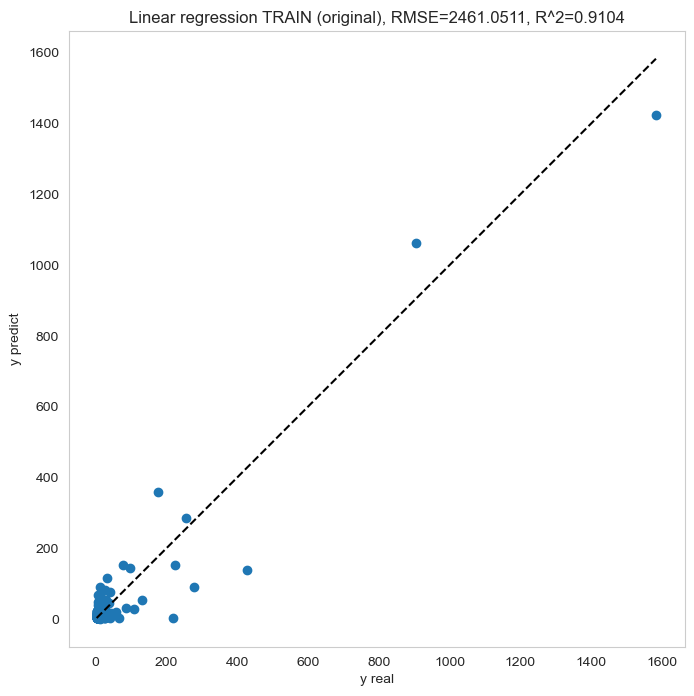

In [259]:
ref = np.linspace(min(y_train),max(y_train))
fig = plt.figure(figsize=(10,8))
plt.scatter(y_train,pred_train)
plt.plot(ref,ref,'k--')
plt.axis('square')
plt.xlabel('y real'),plt.ylabel('y predict')
plt.title('Linear regression TRAIN (original), RMSE=%0.4f, R^2=%0.4f'%(mean_squared_error(y_train,pred_train ),r2_score(y_train,pred_train)))
plt.grid()

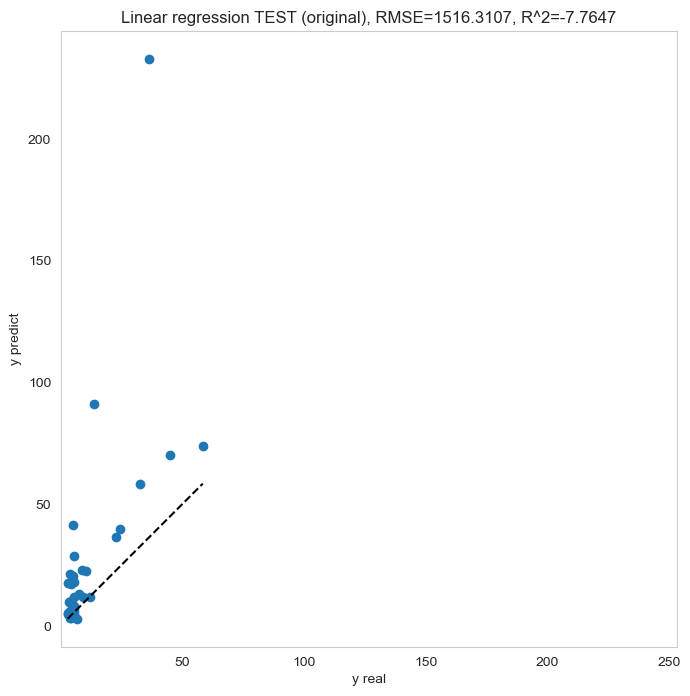

In [262]:
ref = np.linspace(min(y_test),max(y_test))
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,pred_test)
plt.plot(ref,ref,'k--')
plt.axis('square')
plt.xlabel('y real'),plt.ylabel('y predict')
plt.title('Linear regression TEST (original), RMSE=%0.4f, R^2=%0.4f'%(mean_squared_error(y_test,pred_test ),r2_score(y_test,pred_test)))
plt.grid()

In [264]:
y_test.sum()

380.9339999999999

In [265]:
pred_test.sum()

938.3954796005498

## Support Vector Machines

In [266]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import (linear_kernel,polynomial_kernel,rbf_kernel)

In [278]:
epsilon = 5

# Step 1. Create the model
# K(x, x*) = <x, x*>
model_svr = SVR(kernel='poly', epsilon=epsilon, degree=5, coef0=1)

# K(x, x*) = (gamma <x, x*> + coef0)^degree
# model_svr = SVR(kernel='poly', epsilon=epsilon, degree=3,coef0=1)

# K(x, x*) = exp(-gamma ||x-x*||^2)
# model_svr = SVR(kernel='rbf', epsilon=epsilon,gamma=100)

## K(x,x*) = tanh(gamma <x, x*> + coef0)
# model_svr = SVR(kernel='sigmoid', epsilon=epsilon,gamma=15,coef0=1)

In [279]:
# Step 2. Training the model
model_svr.fit(X_train,y_train)

# Step 3. Using the model
pred_train = model_svr.predict(X_train)

# Step 4. Evaluation of results
sv_x = model_svr.support_

print("r2:", model_svr.score(X_train,y_train))


r2: 0.8959853574272946


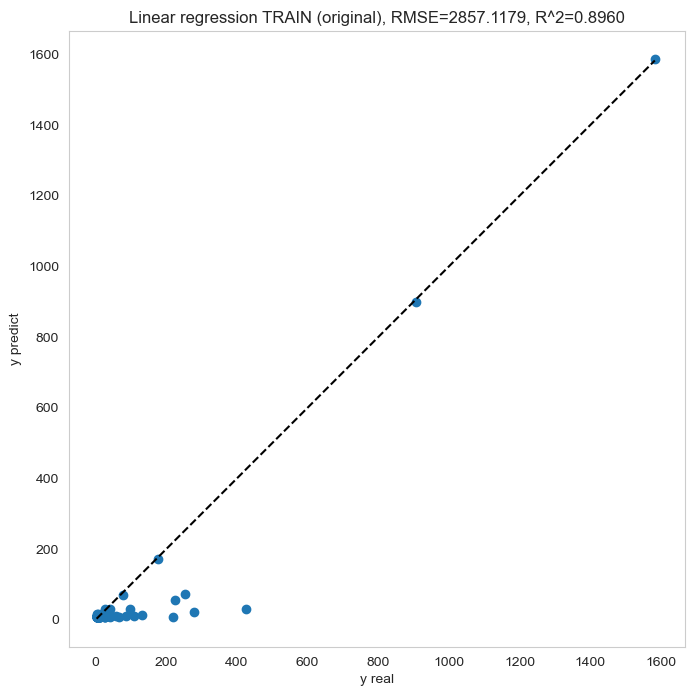

In [280]:
ref = np.linspace(min(y_train),max(y_train))
fig = plt.figure(figsize=(10,8))
plt.scatter(y_train,pred_train)
plt.plot(ref,ref,'k--')
plt.axis('square')
plt.xlabel('y real'),plt.ylabel('y predict')
plt.title('Linear regression TRAIN (original), RMSE=%0.4f, R^2=%0.4f'%(mean_squared_error(y_train,pred_train ),r2_score(y_train,pred_train)))
plt.grid()

In [281]:
# Step 3. Using the model
pred_test = model_svr.predict(X_test)

print("r2:", model_svr.score(X_test,y_test))

r2: 0.4272105549065267


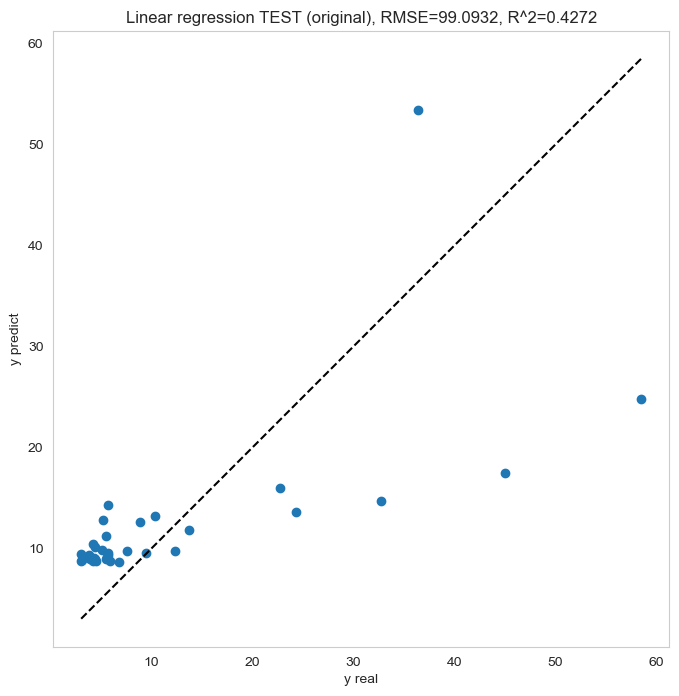

In [282]:
pred_test = model_svr.predict(X_test)
ref = np.linspace(min(y_test),max(y_test))
fig = plt.figure(figsize=(10,8))
plt.scatter(y_test,pred_test)
plt.plot(ref,ref,'k--')
plt.axis('square')
plt.xlabel('y real'),plt.ylabel('y predict')
plt.title('Linear regression TEST (original), RMSE=%0.4f, R^2=%0.4f'%(mean_squared_error(y_test,pred_test ),r2_score(y_test,pred_test)))
plt.grid()

In [283]:
y_test.sum(), pred_test.sum()

(380.9339999999999, 410.1312902522764)

In [462]:
dfr = df[df['md'] == 0]
inputs = df.drop(["time", "Unnamed: 0"], axis=1)
target = df.time

trans_inputs= pd.DataFrame(preprocessing.scale(inputs.drop("md", axis=1)))
trans_inputs.columns = inputs.columns[:6]
X_train, X_, y_train, Y_ = train_test_split(trans_inputs, target, test_size=0.3, random_state=30)
X_cv, X_test, y_cv, y_test = train_test_split(X_, Y_, test_size=0.5, random_state=30)

In [398]:
degrees = [2,3,4] # the values spam to test
r2_train, r2_test, r2_cv = [], [], []
mse_train = []
mse_cv = []
mse_test = []

In [399]:
for degree in degrees:
    model_svr = SVR(kernel='poly', epsilon=epsilon, degree=degree, coef0=1)

    # Step 2. Training the model
    model_svr.fit(X_train,y_train)

    # Step 3. Using the model
    mse_train.append(mean_squared_error(y_train, model_svr.predict(X_train)))
    mse_cv.append(mean_squared_error(y_cv, model_svr.predict(X_cv)))
    mse_test.append(mean_squared_error(y_test, model_svr.predict(X_test)))
    r2_train.append(model_svr.score(X_train,y_train))
    r2_test.append(model_svr.score(X_test,y_test))
    r2_cv.append(model_svr.score(X_cv,y_cv))

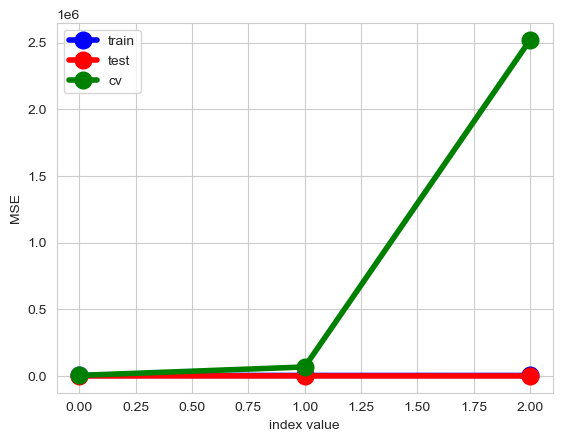

In [400]:
plt.plot(range(len(degrees)), mse_train,linewidth=4, markersize=12, c='b',marker='o', label='train')
plt.plot(range(len(degrees)), mse_test,linewidth=4, markersize=12, c='r',marker='o', label='test')
plt.plot(range(len(degrees)), mse_cv,linewidth=4, markersize=12, c='g',marker='o', label='cv')
plt.xlabel('index value')
plt.ylabel('MSE')
plt.legend()


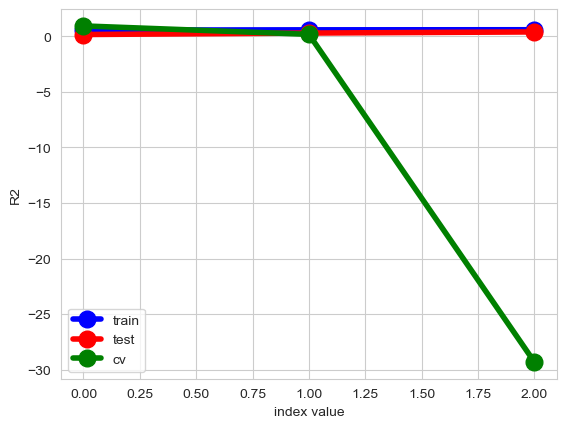

In [401]:
plt.plot(range(len(degrees)), r2_train,linewidth=4, markersize=12, c='b',marker='o', label='train')
plt.plot(range(len(degrees)), r2_test,linewidth=4, markersize=12, c='r',marker='o', label='test')
plt.plot(range(len(degrees)), r2_cv,linewidth=4, markersize=12, c='g',marker='o', label='cv')
plt.xlabel('index value')
plt.ylabel('R2')
plt.legend()

In [396]:
model_svr = SVR(kernel='poly', epsilon=epsilon, degree=2, coef0=1)
model_svr.fit(X_train,y_train)
print("r2:", model_svr.score(X_cv,y_cv))

r2: 0.943916152932164


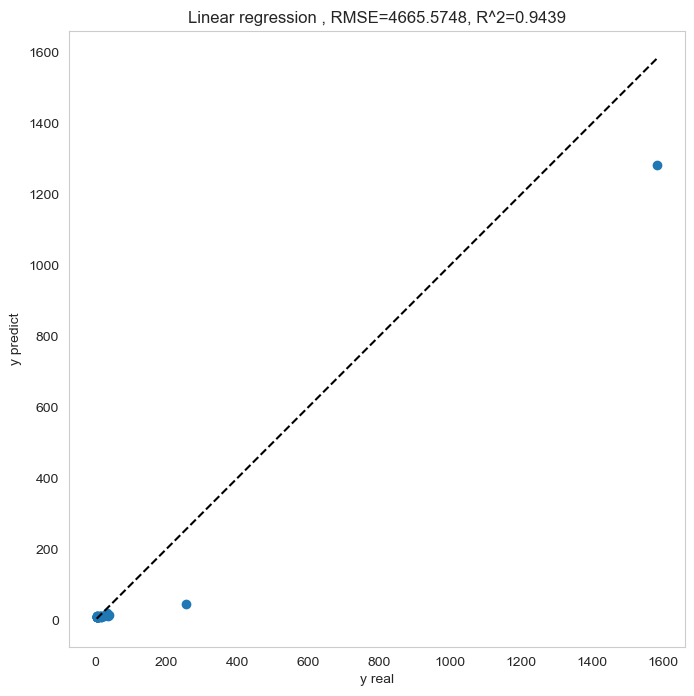

In [397]:
y = y_cv
pred = model_svr.predict(X_cv)
ref = np.linspace(min(y),max(y))
fig = plt.figure(figsize=(10,8))
plt.scatter(y,pred)
plt.plot(ref,ref,'k--')
plt.axis('square')
plt.xlabel('y real'),plt.ylabel('y predict')
plt.title('Linear regression , RMSE=%0.4f, R^2=%0.4f'%(mean_squared_error(y,pred ),r2_score(y,pred)))
plt.grid()

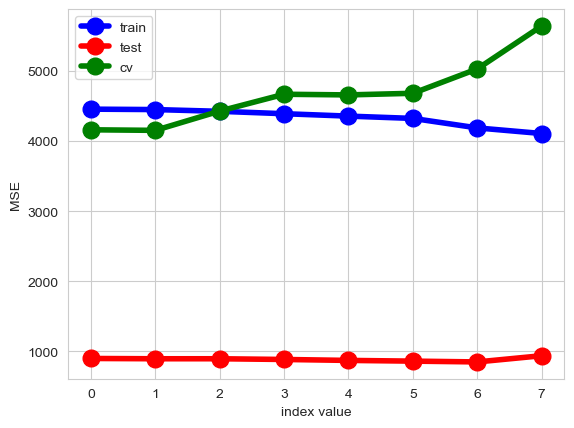

In [405]:
degrees = [0.5, 1, 3, 5, 6,7, 13, 21]  # the values spam to test
r2_train, r2_test, r2_cv = [], [], []
mse_train = []
mse_cv = []
mse_test = []
for epsilon in degrees:
    model_svr = SVR(kernel='poly', epsilon=epsilon, degree=2, coef0=1)

    # Step 2. Training the model
    model_svr.fit(X_train, y_train)

    # Step 3. Using the model
    mse_train.append(mean_squared_error(y_train, model_svr.predict(X_train)))
    mse_cv.append(mean_squared_error(y_cv, model_svr.predict(X_cv)))
    mse_test.append(mean_squared_error(y_test, model_svr.predict(X_test)))
    r2_train.append(model_svr.score(X_train, y_train))
    r2_test.append(model_svr.score(X_test, y_test))
    r2_cv.append(model_svr.score(X_cv, y_cv))
plt.plot(range(len(degrees)), mse_train, linewidth=4, markersize=12, c='b', marker='o', label='train')
plt.plot(range(len(degrees)), mse_test, linewidth=4, markersize=12, c='r', marker='o', label='test')
plt.plot(range(len(degrees)), mse_cv, linewidth=4, markersize=12, c='g', marker='o', label='cv')
plt.xlabel('index value')
plt.ylabel('MSE')
plt.legend()


In [408]:
model_svr = SVR(kernel='poly', epsilon=3, degree=2, coef0=1)
model_svr.fit(X_train, y_train)

SVR(coef0=1, degree=2, epsilon=3, kernel='poly')

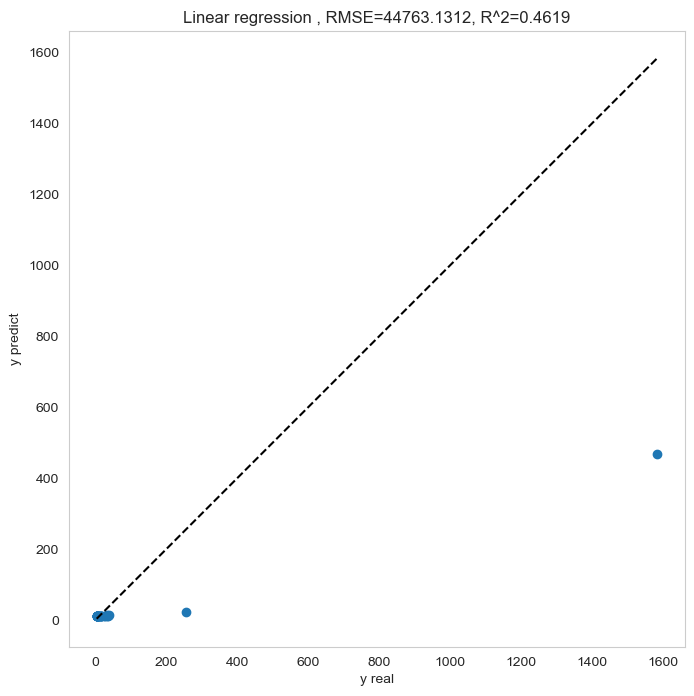

In [463]:
y = y_cv
pred = model_svr.predict(X_cv)
ref = np.linspace(min(y),max(y))
fig = plt.figure(figsize=(10,8))
plt.scatter(y,pred)
plt.plot(ref,ref,'k--')
plt.axis('square')
plt.xlabel('y real'),plt.ylabel('y predict')
plt.title('Linear regression , RMSE=%0.4f, R^2=%0.4f'%(mean_squared_error(y,pred ),r2_score(y,pred)))
plt.grid()

# Que pasa si hago un ensamble

In [496]:
df = pd.read_csv("full_data.csv")
# dfr = df[df['time'] < 100]
inputs = dfr.drop(["time", "Unnamed: 0"], axis=1)
target = dfr.time
inputs

,grants,size,packages,alters,commands,commits,md
0,14,6039,87,2,955,23,0
1,11,5811,87,2,902,17,0
2,11,193,0,0,43,2,0
3,0,36,0,0,9,0,0
4,0,23,0,0,0,0,0
...,...,...,...,...,...,...,...
1844,11,193,0,0,43,2,0
1845,0,34,1,0,7,0,0
1846,11,193,0,0,43,2,0
1847,0,34,1,0,7,0,0


In [497]:
trans_inputs= pd.DataFrame(preprocessing.scale(inputs.drop("md", axis=1)))
trans_inputs.columns = inputs.columns[:6]
X_train, X_, y_train, Y_ = train_test_split(trans_inputs, target, test_size=0.3, random_state=13)
X_cv, X_test, y_cv, y_test = train_test_split(X_, Y_, test_size=0.5, random_state=13)

MSE: 288.0914992906623 480.80922323325126 71.33013921051304 using 1
MSE: 393.1595838239586 230.71159784777336 53.748878581279484 using 2
MSE: 535070.63219657 176.8600056792464 3290.1833952669276 using 3
MSE: 630708096493.866 106.37422612636618 573948.0615573416 using 5
MSE: 1523998428161.5962 880.1802109718129 2424795.113963167 using 6
MSE: 2394949686809705.0 263.0826133618075 30245328.96875767 using 7


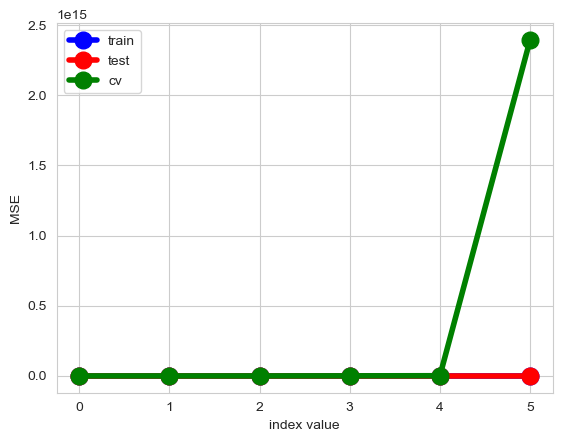

In [498]:
degrees = [1,2, 3, 5, 6,7]  # the values spam to test
r2_train, r2_test, r2_cv = [], [], []
mse_train = []
mse_cv = []
mse_test = []
for degree in degrees:
    model_svr = SVR(kernel='poly', epsilon=7, degree=degree, coef0=1)

    # Step 2. Training the model
    model_svr.fit(X_train, y_train)

    # Step 3. Using the model
    mse_train.append(mean_squared_error(y_train, model_svr.predict(X_train)))
    mse_cv.append(mean_squared_error(y_cv, model_svr.predict(X_cv)))
    print("MSE:", mean_squared_error(y_cv, model_svr.predict(X_cv)), 
          mean_squared_error(y_train, model_svr.predict(X_train)),
          mean_squared_error(y_test, model_svr.predict(X_test)),
          "using", degree)
    mse_test.append(mean_squared_error(y_test, model_svr.predict(X_test)))
    r2_train.append(model_svr.score(X_train, y_train))
    r2_test.append(model_svr.score(X_test, y_test))
    r2_cv.append(model_svr.score(X_cv, y_cv))
plt.plot(range(len(degrees)), mse_train, linewidth=4, markersize=12, c='b', marker='o', label='train')
plt.plot(range(len(degrees)), mse_test, linewidth=4, markersize=12, c='r', marker='o', label='test')
plt.plot(range(len(degrees)), mse_cv, linewidth=4, markersize=12, c='g', marker='o', label='cv')
plt.xlabel('index value')
plt.ylabel('MSE')
plt.legend()


In [499]:
model_svr = SVR(kernel='poly', epsilon=7, degree=2, coef0=1)
model_svr.fit(X_train, y_train)

SVR(coef0=1, degree=2, epsilon=7, kernel='poly')

In [500]:
mean_squared_error(y_cv, model_svr.predict(X_cv))

393.1595838239586

In [501]:
y = y_cv
pred = model_svr.predict(X_cv)

ref = np.linspace(min(y),max(y))
fig = plt.figure(figsize=(10,8))
plt.scatter(y,pred)
plt.plot(ref,ref,'k--')
plt.axis('square')
plt.xlabel('y real'),plt.ylabel('y predict')
plt.title('Linear regression , RMSE=%0.4f, R^2=%0.4f'%(mean_squared_error(y,pred ),r2_score(y,pred)))
plt.grid()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U5'), dtype('float64')) -> None

In [502]:
pred[pred > 100] 

array([728.13300381])

In [503]:
pred

array([  7.19440506,   6.99339906,   7.02923314,   7.33517092,
         7.03593865,   7.0322948 ,   6.96372271,   6.9833584 ,
         7.00731581,   6.966398  ,   6.99877572,   7.31895331,
         6.98023193,   7.37176301,   6.98015696,   6.99877572,
         6.99907532,   7.02870987,   7.01013472,   6.98128148,
         6.98275874,   6.97457678,   6.99907532,   8.19656613,
         7.01013472,   7.03080401,   7.03715137,   6.99915022,
         6.99652609,   7.01193346,   7.14221303,   7.08817541,
         7.10596158,   7.03146834,   7.44871819,   7.00440567,
         7.74425002,   6.99600172,   7.01095772,   7.04818251,
         6.99875469,   7.05528623,   6.9750299 ,   7.03296735,
         8.5744099 ,   7.07035774,   6.99592681,   7.05105816,
         7.05260244,   6.96104791,   7.01350841,   6.98023193,
         7.00798284,   7.17385879,   6.9943642 ,   6.96082267,
         6.98305858,   7.06700631,  14.36603095,   6.97450176,
         7.02062125,   6.9660227 ,   6.99877572,   6.97

In [438]:
X_cv

,grants,size,packages,alters,commands,commits
38,-0.448754,-0.357149,-0.263330,-0.255953,-0.541354,-0.150066
7,-0.200204,-0.245362,-0.156485,-0.074240,-0.303921,-0.182444
17,-0.453443,-0.351089,-0.156485,-0.023763,-0.544641,-0.344334
79,-0.453443,-0.010892,-0.135116,-0.255953,0.529972,-0.344334
51,3.101283,0.596783,-0.263330,-0.255953,2.168183,-0.344334
70,2.083637,-0.223314,-0.263330,-0.255953,-0.114960,-0.344334
46,0.240619,-0.175607,-0.263330,-0.255953,-0.036911,-0.344334
128,-0.082964,1.828442,0.580742,0.006522,3.802285,3.443889
68,1.356747,0.114047,-0.135116,-0.134811,0.898857,-0.117689
18,-0.303376,-0.344965,-0.263330,-0.255953,-0.524923,-0.344334


In [439]:
inputs[128]

KeyError: 128

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    predictors, target, test_size=test_size, random_state=random_state
)
